In [2]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import GroupShuffleSplit


# Ensure reproducibility'
np.random.seed(42)
tf.random.set_seed(42)
#tf.random.set_random_seed(42)

# Material constants
E = 193000e6  # Young's modulus in MPa
sigma_y = 150e6  # Yield stress in MPa
c1, c2, c3 = 230000e6, 19600e6, 1800e6  # Kinematic hardening constants
gamma1, gamma2, gamma3 = 1200, 140, 4  # Hardening constants
b = 8  # Isotropic hardening rate
Q = 110e6  # Isotropic hardening saturation value


# Generate strain history byappointment islamabad accumulating increments
def generate_strain_history(num_samples, lb, ub):
    strain_history = np.zeros(num_samples)
    cumulative_strain = 0  # Start with zero cumulative strain

    # First range: Accumulate small positive strain increments
    for i in range(300):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    # Second range: Accumulate negative strain increments
    for i in range(300, 900):
        increment = np.random.uniform(lb, ub)
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain

    # Third range: Return to positive strain increments
    for i in range(900, num_samples):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    return strain_history



# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    back_stress = sigma_k1 + sigma_k2 + sigma_k3
    yield_function = np.abs(sigma_trial - back_stress) - (sigma_y + sigma_i)
    return sigma_trial, yield_function

# Update kinematic hardening rule
def update_kinematic_hardening(sigma_k, eps_p_dot, c, gamma):
    return ((2.0 / 3.0) * c * eps_p_dot) - (gamma * sigma_k * np.abs(eps_p_dot))

# Update isotropic hardening rule
def update_isotropic_hardening(sigma_i, eps_p_dot, b, Q):
    return b * (Q - sigma_i) * np.abs(eps_p_dot)

# Return mapping algorithm
def return_mapping(eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        return sigma_trial, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i
    else:
        # Plastic corrector step
        def plastic_residual(delta_gamma):
            eps_p_dot = delta_gamma
            back_stress = sigma_k1 + sigma_k2 + sigma_k3                    
            sigma_updated = sigma_trial - E * delta_gamma
            yield_function_updated = np.abs(sigma_updated - back_stress) - (sigma_y + sigma_i)
            return yield_function_updated

        try:
            delta_gamma = newton(plastic_residual, 0, tol=1e-8, maxiter=50)  # Solve for plastic multiplier
        except RuntimeError:
            delta_gamma = 0.0  # If Newton-Raphson fails, assume no plastic deformation

        eps_p += delta_gamma
        sigma_k1 += update_kinematic_hardening(sigma_k1, delta_gamma, c1, gamma1)
        sigma_k2 += update_kinematic_hardening(sigma_k2, delta_gamma, c2, gamma2)
        sigma_k3 += update_kinematic_hardening(sigma_k3, delta_gamma, c3, gamma3)
        sigma_i += update_isotropic_hardening(sigma_i, delta_gamma, b, Q)

        # Final stress update
        sigma_updated = sigma_trial-E*delta_gamma
        return sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i


# Generate dataset
def generate_dataset(lb, ub, num_strain_samples):
    dataset = []
    strain_history = generate_strain_history(num_strain_samples, lb, ub)

    # Initialize state variables
    sigma_k1, sigma_k2, sigma_k3, sigma_i, eps_p = 0, 0, 0, 0, 0

    for eps in strain_history:
        # Elastic predictor
        sigma_trial, yield_function = elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y)

        # Return mapping algorithm
        sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i = return_mapping(
            eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, E, sigma_y
        )

        # Store the data
        back_stress = sigma_k1 + sigma_k2 + sigma_k3
        trial_phi=yield_function
        dataset.append([
            E, sigma_y, c1, gamma1, c2, gamma2, c3, gamma3, 
            b, Q, trial_phi, eps, back_stress, sigma_i, sigma_updated, eps_p
        ])

    return np.array(dataset)


# Save the dataset to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset_training20.11.csv"):
    columns = [E, sigma_y, c[0],gamma[0], c[1],gamma[1], c[2],gamma[2],
                b, Q, trial_phi,
                strain,          # Strain
                stress_rm,    # Stress from Return Mapping
                plastic_strain]
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")



2024-12-05 17:12:13.373839: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 17:12:13.374527: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 17:12:13.376724: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 17:12:13.382926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 17:12:13.393333: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [3]:
training = generate_dataset(lb=0.0001,ub=0.0002, num_strain_samples=1500)
test1 = generate_dataset(lb=0,ub=0.0001, num_strain_samples=1500)
test2 = generate_dataset(lb=0.0002,ub=0.0004, num_strain_samples=1500)

In [4]:
columns = ['E', 'sigma_y', 'c[0]','gamma[0]', 'c[1]','gamma[1]', 'c[2]','gamma[2]','b', 'Q', 'trial_phi',
            'strain', 'back_stress', 'sigma_i',          # Strain
            'stress_rm',    # Stress from Return Mapping
            'plastic_strain']
df = pd.DataFrame(training, columns=columns)

In [5]:
df.head(50)

,E,sigma_y,c[0],gamma[0],c[1],gamma[1],c[2],gamma[2],b,Q,trial_phi,strain,back_stress,sigma_i,stress_rm,plastic_strain
0,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,-1.234714e+08,0.000137,0.000000e+00,0.000000e+00,2.652862e+07,0.000000
1,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,-8.582259e+07,0.000333,0.000000e+00,0.000000e+00,6.417741e+07,0.000000
2,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,-5.239511e+07,0.000506,0.000000e+00,0.000000e+00,9.760489e+07,0.000000
3,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,-2.154100e+07,0.000666,0.000000e+00,0.000000e+00,1.284590e+08,0.000000
4,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,7.701620e+05,0.000781,6.688039e+05,3.511619e+03,1.500000e+08,0.000004
5,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,2.163838e+07,0.000897,1.937630e+07,1.021705e+05,1.506723e+08,0.000116
6,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,1.614863e+06,0.001003,2.059893e+07,1.095268e+05,1.694785e+08,0.000124
7,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,3.478721e+07,0.001189,4.669496e+07,2.679841e+05,1.707085e+08,0.000305
8,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,4.647025e+06,0.001349,4.949227e+07,2.891210e+05,1.969629e+08,0.000329
9,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,3.014736e+07,0.001520,6.717061e+07,4.262192e+05,1.997814e+08,0.000485


In [6]:
strain_training= training[:,11]
strain_test1= test1[:,11]
strain_test2= test2[:,11]

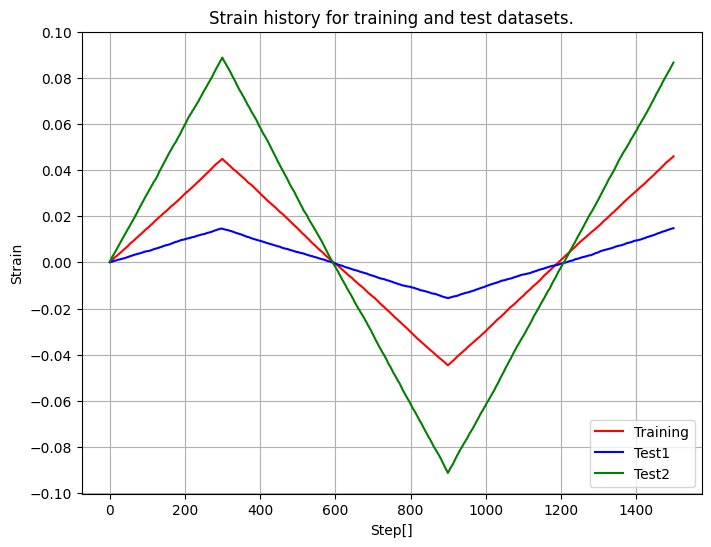

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(strain_training, label='Training', color='red')
plt.plot(strain_test1, label='Test1', color='blue')
plt.plot(strain_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Strain')
plt.title('Strain history for training and test datasets.')

y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [8]:
plastic_strain_training= training[:,-1]
plastic_strain_test1= test1[:,-1]
plastic_strain_test2= test2[:,-1]

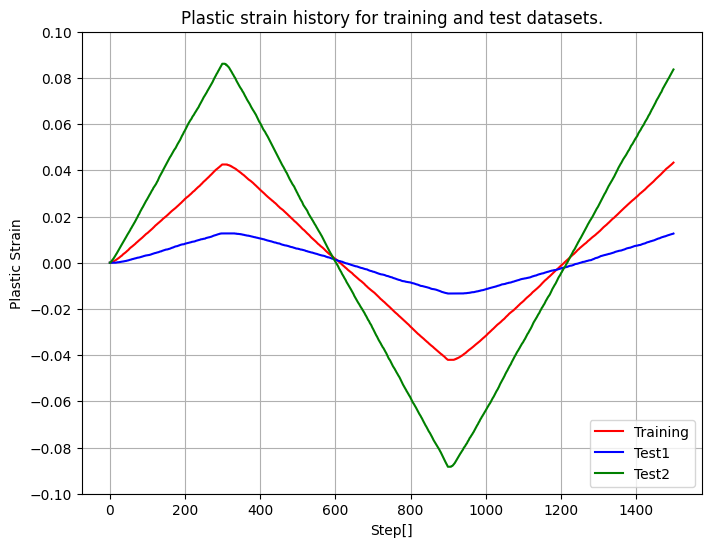

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(plastic_strain_training, label='Training', color='red')
plt.plot(plastic_strain_test1, label='Test1', color='blue')
plt.plot(plastic_strain_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Plastic Strain')
plt.title('Plastic strain history for training and test datasets.')

y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [10]:
stress_rm_training= training[:,-2]
stress_rm_test1= test1[:,-2]
stress_rm_test2= test2[:,-2]

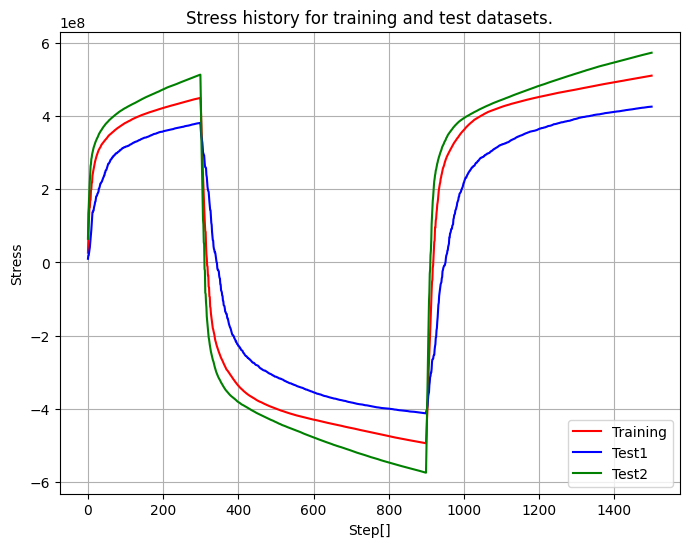

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(stress_rm_training, label='Training', color='red')
plt.plot(stress_rm_test1, label='Test1', color='blue')
plt.plot(stress_rm_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Stress')
plt.title('Stress history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [12]:
trail_phi_training= training[:,10]
trail_phi_test1= test1[:,10]
trail_phi_test2= test2[:,10]

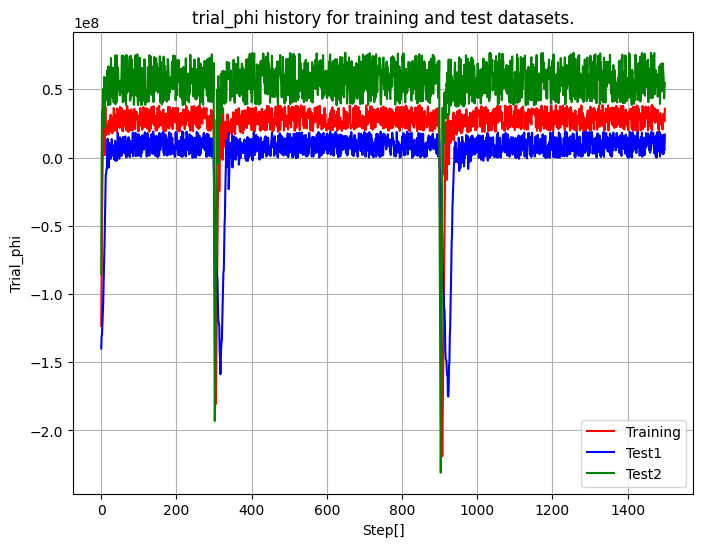

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(training[:,10], label='Training', color='red')
plt.plot(trail_phi_test1, label='Test1', color='blue')
plt.plot(trail_phi_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Trial_phi')
plt.title('trial_phi history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

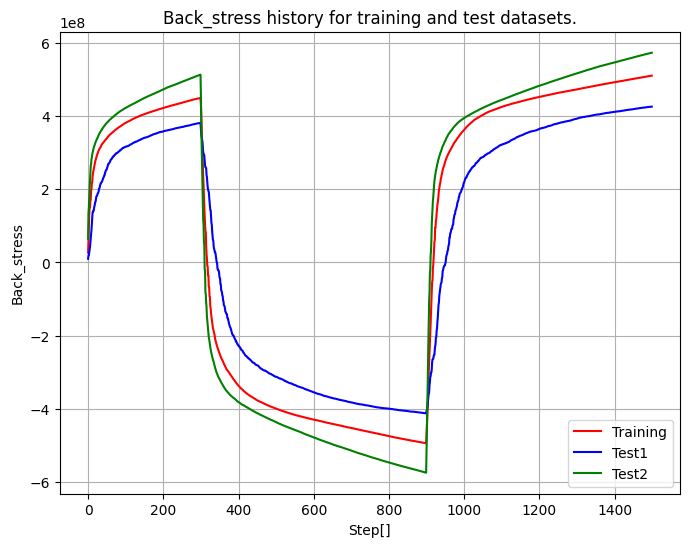

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(training[:,-2], label='Training', color='red')
plt.plot(test1[:,-2], label='Test1', color='blue')
plt.plot(test2[:,-2], label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Back_stress')
plt.title('Back_stress history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

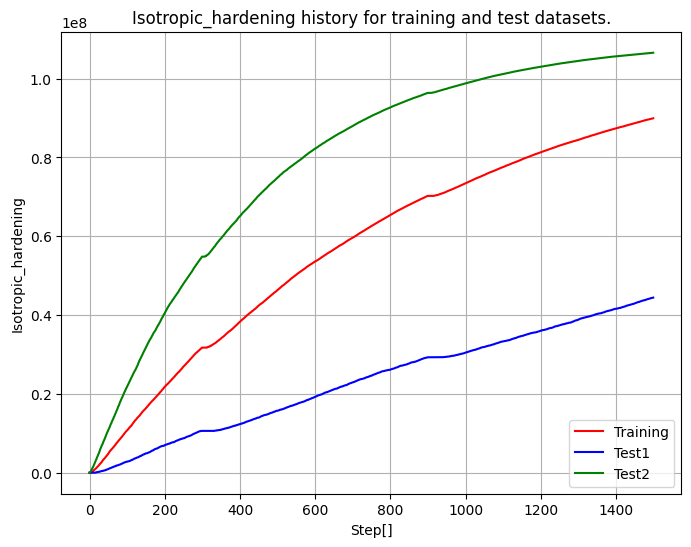

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(training[:,-3], label='Training', color='red')
plt.plot(test1[:,-3], label='Test1', color='blue')
plt.plot(test2[:,-3], label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Isotropic_hardening')
plt.title('Isotropic_hardening history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

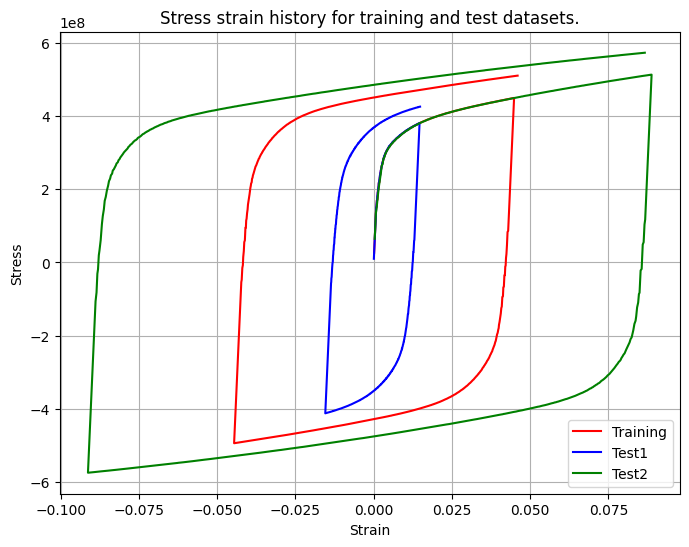

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(training[:,11], training[:,-2], label='Training', color='red')
plt.plot(test1[:,11], test1[:,-2], label='Test1', color='blue')
plt.plot(test2[:,11], test2[:,-2], label='Test2', color='green')
plt.xlabel('Strain')
plt.ylabel('Stress')
plt.title('Stress strain history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()